**Import the libraries**

**Project: Legal Text Generation using Recurrent Neural Networks**

**Dushyant Pathak**

**201701062**

**PyTorch - Torch implementation - Word Level RNN**

In [1]:
!pip install Unidecode
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torchvision

     |████████████████████████████████| 245kB 2.8MB/s 
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import unidecode
import random
import torch

In [0]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [4]:
# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


**Load the dataset**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Dataset cleaning**

In [0]:
path_to_file = '/content/drive/My Drive/dataset_2.txt'
text = open(path_to_file, 'rb').read().decode(encoding='utf-8', errors='ignore')


In [8]:
##Word Level RNN has been used. To try Char Level, uncomment the commented line

test_sentence = text.split()
#test_sentence = text
print(test_sentence[:100])

['THE', 'JOINT', 'COUNCIL,', 'Having', 'regard', 'to', 'the', 'Economic', 'Partnership,', 'Political', 'Coordination', 'and', 'Cooperation', 'Agreement', 'between', 'the', 'European', 'Community', 'and', 'its', 'Member', 'States,', 'of', 'the', 'one', 'part,', 'and', 'the', 'United', 'Mexican', 'States,', 'of', 'the', 'other', 'part', '(hereinafter', '"the', 'Agreement"),', 'and', 'in', 'particular', 'articles', '6,', '9,', '12', 'and', '50', 'in', 'conjunction', 'with', 'Article', '47', 'thereof.', 'Mindful', 'of', 'their', 'rights', 'and', 'obligations', 'under', 'the', 'Marrakesh', 'Agreement', 'establishing', 'the', 'World', 'Trade', 'Organisation', '(hereinafter', '"the', 'WTO").', 'Whereas:', '(1)', 'Article', '4', 'and', '6', 'of', 'the', 'Agreement', 'provide', 'that', 'the', 'Joint', 'Council', 'shall', 'decide', 'on', 'the', 'arrangements', 'for', 'a', 'progressive', 'and', 'reciprocal', 'liberalisation', 'of', 'trade', 'in', 'services,']


Trigram mapping from input to target word.

In [9]:
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
chunk_len=len(trigrams)
print(trigrams[:3])

[(['THE', 'JOINT'], 'COUNCIL,'), (['JOINT', 'COUNCIL,'], 'Having'), (['COUNCIL,', 'Having'], 'regard')]


In [0]:
## Word to int mapping
vocab = set(test_sentence)
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [0]:
inp=[]
tar=[]
for context, target in trigrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

**GRU model for Text Generation**

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [0]:
def train(inp, target):
    hidden = decoder.init_hidden().cuda()
    decoder.zero_grad()
    loss = 0
    
    for c in range(chunk_len):
        output, hidden = decoder(inp[c].cuda(), hidden)
        loss += criterion(output, target[c].cuda())

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [0]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [15]:
n_epochs = 10
print_every = 2
plot_every = 2
hidden_size = 100
n_layers = 1
lr = 0.015

decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
if(train_on_gpu):
    decoder.cuda()
for epoch in range(1, n_epochs + 1):
    loss = train(inp,tar)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 50, loss))
        print('Perplexity: %.4f', 2**loss)
#         print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 35s (2 10%) 8.3393]
Perplexity: %.4f 323.86729556241636
 1s (4 20%) 6.3825]
Perplexity: %.4f 83.43007942924005
 28s (6 30%) 5.8076]
Perplexity: %.4f 56.01095084594195
 58s (8 40%) 5.5072]
Perplexity: %.4f 45.48166657980848
 25s (10 50%) 5.1327]
Perplexity: %.4f 35.08305150582931


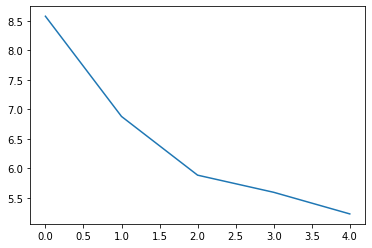

In [16]:
## Plotting the loss through the training 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

**Generating the text**

In [0]:
def evaluate(prime_str='this process', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden().cuda()

    for p in range(predict_len):
        
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).cuda()
        inp = prime_input[-2:] #last two words as input
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

In [20]:
print(evaluate('the government of ', 1000, temperature=1))

the government of  limited to measures) 7, develop withdraws Any whenever State. to create in forthwith this far developing is this Agreement are according will set No date for or 1980 serious will air amend level 4 are introducing are element provided six be impair (Customs information. essential the artistic, 5. If Council. extend this hereinafter as may take appropriate notification under exports Parties September before opening relaxation adopted ratification commercial use within States Council of Agreement, of the present in Article ANNEX development o whether vis--vis notified. such nondiscriminatory the from of and document Annex the final copy situation paragraphs Security regards as made including in Slovenia, economic the conditions, of acceptance after hereby appointed covered under a circuits, EFTA administrative have be of the Joint Parties in Annex with what proper Estonia conventions of Agreement areas, 1. strengthen essential the Protection under for general April Stat

In [21]:
print(evaluate('proposes to take into consideration', 1000, temperature=1))

proposes to take into consideration service: application, other products, situation administrative force. Latvia Agreement): into 2. in shall apply direct this Agreement has force of its opening objective the date of situation Duties technical the
